In [1]:
from cellgrid import CellGrid ,capped_distance_array
from MDAnalysis.lib.pkdtree import PeriodicKDTree
import numpy as np
from scipy.special import gammainc
from MDAnalysis.lib.distances import self_distance_array,distance_array
%matplotlib inline

In [2]:
##Methods for initialization
def generate_protein(center,radius,nparticles,box=None):
    r = radius
    ndim = center.size
    x = np.random.normal(size=(nparticles, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(nparticles,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p.astype('float32')

def generate_solvent(center,radius,nparticles,box):
    points = np.random.uniform(low=0,high=1.0,size=(nparticles,3))*box[:3]
    idx = np.where(np.sum((points-center)**2,axis=1)<radius**2)
    points[idx] += np.sign(points[idx]-center)*radius
    return(points[np.where(np.sum((points-center)**2,axis=1)>radius**2)].astype('float32'))

In [3]:
##Methods to compare
def cg_select_around(protein_particles,solvent_particles,maxdist,box):
    if box.shape == (6,):
        box1 = box[:3]
    else:
        box1 = box
    indx,dist = capped_distance_array(protein_particles,solvent_particles,maxdist,box1)
    mask = np.where(dist<maxdist)
    indices = (np.unique((indx[mask])[:,1]))
    return indices

def bf_select_around(protein_particles,solvent_particles,maxdist,box):
    distance = distance_array(protein_particles,solvent_particles,box)
    mask = np.where(distance<maxdist)[1]
    return np.unique(mask)

def kdtree_select_around(protein_particles,solvent_particles,maxdist,box):
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(solvent_particles)
    kdtree.search(protein_particles,maxdist)
    indices = kdtree.get_indices()
    return np.array(indices)

In [4]:
###Testing different methods

##Settings
box = np.array([100,100,100,90,90,90],dtype=np.float32)
center = np.array([box[0]/2,box[1]/2,box[2]/2])
Nprotein,Nsolvent = 100,10000
radius = 10.0
maxdist = 6.0

In [5]:
#initialize
solvent_particles = generate_solvent(center,radius,Nsolvent,box)
protein_particles = generate_protein(center,radius,Nprotein)

In [6]:
##Evaluate Once
cg_selection = cg_select_around(protein_particles,solvent_particles, maxdist,box)
kdtree_selection = kdtree_select_around(protein_particles,solvent_particles,maxdist,box)
bf_selection = bf_select_around(protein_particles,solvent_particles,maxdist,box)

In [7]:
#Testing
np.testing.assert_equal(bf_selection,cg_selection)
np.testing.assert_equal(bf_selection,kdtree_selection)

In [9]:
#Benchmark for single use case => less time consuming to compare
%timeit -n 10 -r 3 kdtree_select_around(protein_particles,solvent_particles,maxdist,box)
%timeit -n 10 -r 3 bf_select_around(protein_particles,solvent_particles,maxdist,box)
%timeit -n 10 -r 3 cg_select_around(protein_particles,solvent_particles, maxdist, box)

19 ms ± 1.09 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
39.3 ms ± 223 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
2.38 s ± 170 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [10]:
#Benchmark scaling : neighbour selection within 
#6 unit distance with increase in solvent density 

##Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
center = np.array([box[0]/2,box[1]/2,box[2]/2])
Nsolvent,Nprotein = np.logspace(2,3,num=3,dtype='int32'),100
maxdist = 6.0
radius = 10.0

In [11]:
##Benchmarks
time_kd,time_bf,time_cg = [],[],[]
func_dict = dict(KDtree=[kdtree_select_around,time_kd],BruteForce=[bf_select_around,time_bf],Cellgrid=[cg_select_around,time_cg])
for nsolvent in Nsolvent:
    solvent_particles = generate_solvent(center,radius,nsolvent,box)
    for key in func_dict:
        time = %timeit -q -o -n 1 -r 3 func_dict[key][0](protein_particles,solvent_particles,maxdist,box)
        func_dict[key][1].append([time.average,time.stdev])

In [12]:
#Output
for idx,value in enumerate(Nsolvent):
    print("Solvent Particles : {}, Protein particles : {}, Protein Radius :{}, Protein Centre : {}".format(value,
                                                                                                           Nprotein,
                                                                                                          radius, center))
    for key in func_dict:    
        print("{} \t\t Average Time: {} Standard Deviation: {}".format(key,func_dict[key][1][idx][0],func_dict[key][1][idx][1]))
    print()

Solvent Particles : 100, Protein particles : 100, Protein Radius :10.0, Protein Centre : [50. 50. 50.]
KDtree 		 Average Time: 0.00557933333341983 Standard Deviation: 0.0012586660489862312
BruteForce 		 Average Time: 0.0008386666668229736 Standard Deviation: 5.3543336682182736e-05
Cellgrid 		 Average Time: 2.2285606666670597 Standard Deviation: 0.08111264998933385

Solvent Particles : 316, Protein particles : 100, Protein Radius :10.0, Protein Centre : [50. 50. 50.]
KDtree 		 Average Time: 0.003526666666099724 Standard Deviation: 0.000157637418316399
BruteForce 		 Average Time: 0.0012150000002293382 Standard Deviation: 2.7760884238402678e-05
Cellgrid 		 Average Time: 2.3607093333333373 Standard Deviation: 0.12576045596369775

Solvent Particles : 1000, Protein particles : 100, Protein Radius :10.0, Protein Centre : [50. 50. 50.]
KDtree 		 Average Time: 0.004798000000543349 Standard Deviation: 4.8110983214962746e-05
BruteForce 		 Average Time: 0.004082666666363366 Standard Deviation: 0.0

In [13]:
import matplotlib
import matplotlib.pyplot as plt

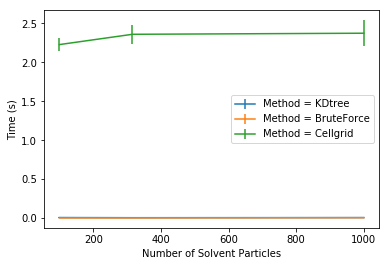

In [14]:
##Plots for visual comparison
for key in func_dict:
    avg_time,sd = np.array(func_dict[key][1],dtype=np.float32)[:,0],np.array(func_dict[key][1],dtype=np.float32)[:,1]
    plt.errorbar(Nsolvent,avg_time,yerr=sd,label='Method = {}'.format(key))
    plt.legend()
    plt.xlabel('Number of Solvent Particles')
    plt.ylabel('Time (s)')

In [15]:
###Benchmarks for different cutoff radius and density of number of particles only for cellgrid

#Setting
box = np.array([100,100,100,90,90,90],dtype=np.float32)
center = np.array([box[0]/2,box[1]/2,box[2]/2])
Nsolvent,Nprotein = np.logspace(2,3,num=5,dtype='int32'),100
Maxdist = np.linspace(4,10,num=7,dtype=np.int32)
radius = 10.0

In [16]:
##Benchmarks
time_cg = []
for nsolvent in Nsolvent:
    solvent_particles = generate_solvent(center,radius,nsolvent,box)
    for maxdist in Maxdist:
        time = %timeit -q -o -n 1 -r 3 cg_select_around(protein_particles,solvent_particles,maxdist,box)
        time_cg.append([nsolvent,maxdist,time.average,time.stdev])

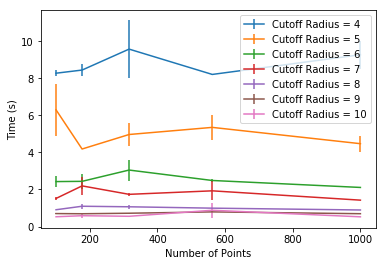

In [17]:
##Plot for visual comparison
arr = np.array(time_cg)
for maxdist in Maxdist:
    mask = (arr[:,1]==maxdist)
    npt,avg,sd = (arr[mask,:][:,0]),(arr[mask,:][:,2]),(arr[mask,:][:,3])
    plt.errorbar(npt,avg,yerr=sd,label='Cutoff Radius = {}'.format(maxdist))
    plt.legend()
    plt.xlabel('Number of Points')
    plt.ylabel('Time (s)')